Handout: Explaining Clusters - example
    <ol>
    <li>Goal</li>
    You clustered your dataset (e.g. patient samples). Now: which features define each cluster?
    <li>Workflow</li>
        <ol>
        <li>Summarize features by cluster</li>
            <ul>
                <li>Continuous: mean, std, median.</li>
            </ul>
            <ul>
                <li>Binary: counts, proportions.</li>
            </ul>
        <li>Test differences</li>
            <ul>
                <li>Continuous → ANOVA/Kruskal-Wallis + Cohen’s d effect size.</li>
            </ul>
            <ul>
                <li>Binary → Chi-square/Fisher + difference in proportions.</li>
            </ul>
            <ul>
                <li>Adjust p-values (Benjamini–Hochberg).</li>
            </ul>
        <li>Multivariate check</li>
            <ul>
                <li>Train a Random Forest (or logistic regression) to predict cluster labels.</li>
            </ul>
            <ul>
                <li>Look at feature importance (permutation / SHAP).</li>
            </ul>
        <li>Interpret clusters</li>
            <ul>
                <li>Combine univariate + multivariate evidence.</li>
            </ul>
            <ul>
                <li>Example: Cluster 2 = high BMI, high diabetes prevalence, older patients.</li>
            </ul>
        <li>Visualize</li>
            <ul>
                <li>Heatmap of feature means per cluster (or Heatmap of sample features, after reordering samples
            by cluster).</li>
            </ul>
            <ul>
                <li>Boxplots for key continuous vars</li>
            </ul>
            <ul>
                <li>Bar plots for binary vars.</li>
            </ul>
            <ul>
                <li>UMAP/t-SNE scatter colored by features.</li>
            </ul>
        </ol>
    </ol>

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from scipy.stats import f_oneway, kruskal, chi2_contingency
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


Normalization and clustering

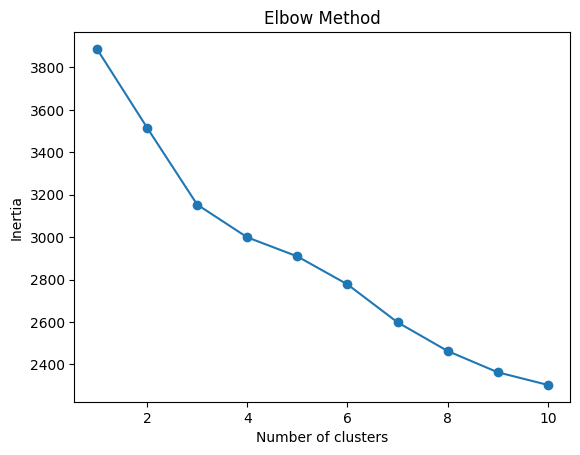

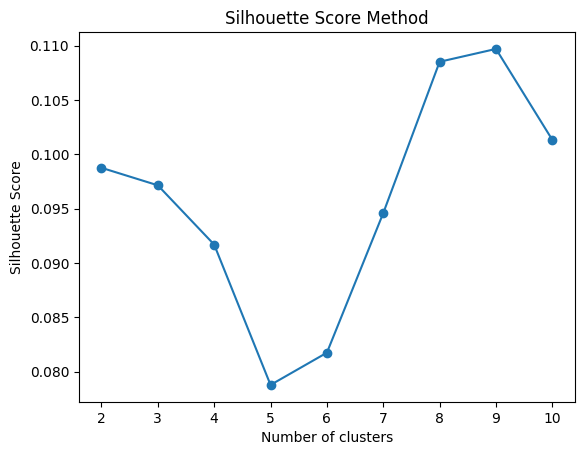

In [3]:
# Let's separate the features
X = df.copy()

continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

# Standardization
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# elbow method to find optimal number of clusters
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# silhouette score to find optimal number of clusters
silhouette_scores = []
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score Method')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

# Clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Adding clusters to the dataframe
df['cluster'] = clusters


Explained variance ratios: [0.15622596 0.12776378]


C:\Users\nicki\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


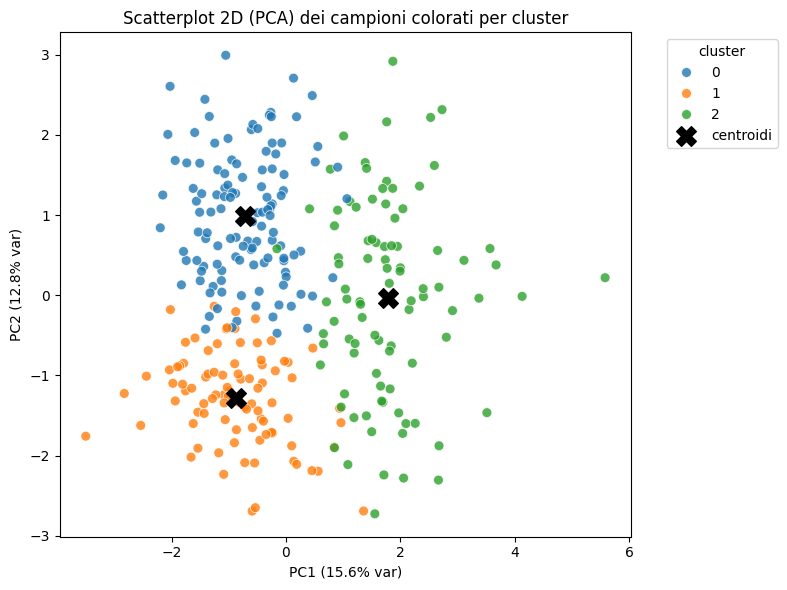

In [ ]:
from sklearn.decomposition import PCA

# Riduzione a 2D con PCA sui dati normalizzati (X_scaled esiste già)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
# Scatterplot 2D con colorazione per cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=clusters, palette='tab10', s=50, alpha=0.8)

# Mostra i centroidi del KMeans proiettati nello spazio PCA (se kmeans è presente)
try:
    centers_2d = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='black', s=200, marker='X', label='centroidi')
except Exception:
    pass

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('Scatterplot 2D (PCA) dei campioni colorati per cluster')
plt.legend(title='cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [5]:
# Summarize features by cluster
# Continuous: mean, std, median.
# Binary: counts, proportions.

summary = {}
for col in X.columns:
    if col in continuous_vars:
        summary[col] = df.groupby('cluster')[col].agg(['mean', 'std', 'median']).reset_index()
    elif col in binary_vars:
        summary[col] = df.groupby('cluster')[col].agg(['sum', 'count']).reset_index()
        summary[col]['proportion'] = summary[col]['sum'] / summary[col]['count']
# Display summary statistics
for col, stats in summary.items():
    print(f"Feature: {col}")
    print(stats)
    print("-" * 40)

Feature: age
   cluster       mean        std  median
0        0  58.084034  10.588273    58.0
1        1  59.232213  10.703111    60.0
2        2  65.996341  13.038166    65.0
----------------------------------------
Feature: anaemia
   cluster  sum  count  proportion
0        0   42    119    0.352941
1        1   41     89    0.460674
2        2   46     91    0.505495
----------------------------------------
Feature: creatinine_phosphokinase
   cluster        mean          std  median
0        0  638.789916   895.185862   250.0
1        1  460.741573   542.677716   244.0
2        2  625.802198  1325.860418   250.0
----------------------------------------
Feature: diabetes
   cluster  sum  count  proportion
0        0   40    119    0.336134
1        1   46     89    0.516854
2        2   39     91    0.428571
----------------------------------------
Feature: ejection_fraction
   cluster       mean        std  median
0        0  37.403361   9.282131    35.0
1        1  44.528090  12

Univariate analysis: differences between clusters

Continuous variables → ANOVA / Kruskal

In [6]:
#continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
results = []

for var in continuous_vars:
    groups = [df[df['cluster'] == c][var] for c in df['cluster'].unique()]
    stat, p = f_oneway(*groups)  # oppure kruskal(*groups)
    results.append({'variable': var, 'p_value': p})

res_df = pd.DataFrame(results)
res_df.sort_values('p_value')

,variable,p_value
6,time,8.392002e-23
2,ejection_fraction,1.856391e-11
4,serum_creatinine,1.079829e-10
5,serum_sodium,1.129448e-07
0,age,2.193058e-06
3,platelets,3.525106e-02
1,creatinine_phosphokinase,3.722532e-01


Binary variables → Chi-square

In [7]:
#binary_vars = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']

chi_results = []
for var in binary_vars:
    contingency = pd.crosstab(df[var], df['cluster'])
    chi2, p, _, _ = chi2_contingency(contingency)
    chi_results.append({'variable': var, 'p_value': p})

chi_df = pd.DataFrame(chi_results)
chi_df.sort_values('p_value')


,variable,p_value
5,DEATH_EVENT,8.535645e-50
3,sex,2.763214e-37
4,smoking,3.412270e-16
2,high_blood_pressure,4.566970e-04
1,diabetes,3.182748e-02
0,anaemia,6.946420e-02


Multivariate analysis (Random Forest to understand feature importance)

In [8]:
X_scaled

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,1.192945,-0.871105,0.000166,-0.847579,-1.530560,1.359272,1.681648e-02,0.490057,-1.504036,0.735688,-0.687682,-1.629502,1.454161
1,-0.491279,-0.871105,7.514640,-0.847579,-0.007077,-0.735688,7.535660e-09,-0.284552,-0.141976,0.735688,-0.687682,-1.603691,1.454161
2,0.350833,-0.871105,-0.449939,-0.847579,-1.530560,-0.735688,-1.038073e+00,-0.090900,-1.731046,0.735688,1.454161,-1.590785,1.454161
3,-0.912335,1.147968,-0.486071,-0.847579,-1.530560,-0.735688,-5.464741e-01,0.490057,0.085034,0.735688,-0.687682,-1.590785,1.454161
4,0.350833,1.147968,-0.435486,1.179830,-1.530560,-0.735688,6.517986e-01,1.264666,-4.682176,-1.359272,-0.687682,-1.577879,1.454161
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,-0.871105,-0.537688,1.179830,-0.007077,1.359272,-1.109765e+00,-0.284552,1.447094,0.735688,1.454161,1.803451,-0.687682
295,-0.491279,-0.871105,1.278215,-0.847579,-0.007077,-0.735688,6.802472e-02,-0.187726,0.539054,-1.359272,-0.687682,1.816357,-0.687682
296,-1.333392,-0.871105,1.525979,1.179830,1.854958,-0.735688,4.902082e+00,-0.575031,0.312044,-1.359272,-0.687682,1.906697,-0.687682
297,-1.333392,-0.871105,1.890398,-0.847579,-0.007077,-0.735688,-1.263389e+00,0.005926,0.766064,0.735688,1.454161,1.932509,-0.687682


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

X = X_scaled.drop(columns=['cluster'])

X_train, X_test, y_train, y_test = train_test_split(X, clusters, test_size=0.3, random_state=42)

# use Gradient Boosting
try:
    gb
except NameError:
    gb = GradientBoostingClassifier(random_state=42)
else:
    # if gb exists but is not a GradientBoostingClassifier, recreate it
    if not isinstance(gb, GradientBoostingClassifier):
        gb = GradientBoostingClassifier(random_state=42)

gb.fit(X_train, y_train)

print(classification_report(y_test, gb.predict(X_test)))

# Importance with permutation importance
perm = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': X.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
importance_df

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.91      0.91      0.91        23
           2       0.86      0.94      0.90        34

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.91      0.91      0.91        90



,feature,importance
12,DEATH_EVENT,3.177778e-01
9,sex,2.133333e-01
4,ejection_fraction,5.222222e-02
11,time,2.333333e-02
10,smoking,2.111111e-02
7,serum_creatinine,6.666667e-03
8,serum_sodium,3.333333e-03
5,high_blood_pressure,1.111111e-03
0,age,0.000000e+00
3,diabetes,0.000000e+00


Removing features with negative values trying to get better results

In [ ]:
features_to_drop = [
    "age",
    "anaemia",
    "platelets",
    "creatinine_phosphokinase",
    "serum_sodium",
    "diabetes"
]

X_reduced = X.drop(columns=features_to_drop)

X_train_new, X_test_new, y_train, y_test = train_test_split(X_reduced, clusters, test_size=0.3, random_state=42)

# create models only if they don't already exist in the notebook namespace
if 'gb_new' not in globals():
    gb_new = GradientBoostingClassifier(random_state=42)
if 'rf_new' not in globals():
    rf_new = RandomForestClassifier(random_state=42)

# Fit the random forest on the reduced feature set
rf_new.fit(X_train_new, y_train)

print("New Classification Report (with fewer features):")
print(classification_report(y_test, rf_new.predict(X_test_new)))

# Permutation importance for the fitted model
perm = permutation_importance(rf_new, X_test_new, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({'feature': X_reduced.columns, 'importance': perm.importances_mean}).sort_values('importance', ascending=False)
importance_df

New Classification Report (with fewer features):
              precision    recall  f1-score   support

           0       0.97      0.91      0.94        33
           1       0.91      0.91      0.91        23
           2       0.92      0.97      0.94        34

    accuracy                           0.93        90
   macro avg       0.93      0.93      0.93        90
weighted avg       0.93      0.93      0.93        90



,feature,importance
6,DEATH_EVENT,0.306667
3,sex,0.187778
4,smoking,0.060000
5,time,0.030000
0,ejection_fraction,0.024444
2,serum_creatinine,0.011111
1,high_blood_pressure,0.006667


In [11]:
X_reduced

,ejection_fraction,high_blood_pressure,serum_creatinine,sex,smoking,time,DEATH_EVENT
0,-1.530560,1.359272,0.490057,0.735688,-0.687682,-1.629502,1.454161
1,-0.007077,-0.735688,-0.284552,0.735688,-0.687682,-1.603691,1.454161
2,-1.530560,-0.735688,-0.090900,0.735688,1.454161,-1.590785,1.454161
3,-1.530560,-0.735688,0.490057,0.735688,-0.687682,-1.590785,1.454161
4,-1.530560,-0.735688,1.264666,-1.359272,-0.687682,-1.577879,1.454161
...,...,...,...,...,...,...,...
294,-0.007077,1.359272,-0.284552,0.735688,1.454161,1.803451,-0.687682
295,-0.007077,-0.735688,-0.187726,-1.359272,-0.687682,1.816357,-0.687682
296,1.854958,-0.735688,-0.575031,-1.359272,-0.687682,1.906697,-0.687682
297,-0.007077,-0.735688,0.005926,0.735688,1.454161,1.932509,-0.687682


<b>Visualization</b>

Heatmap of cluster averages

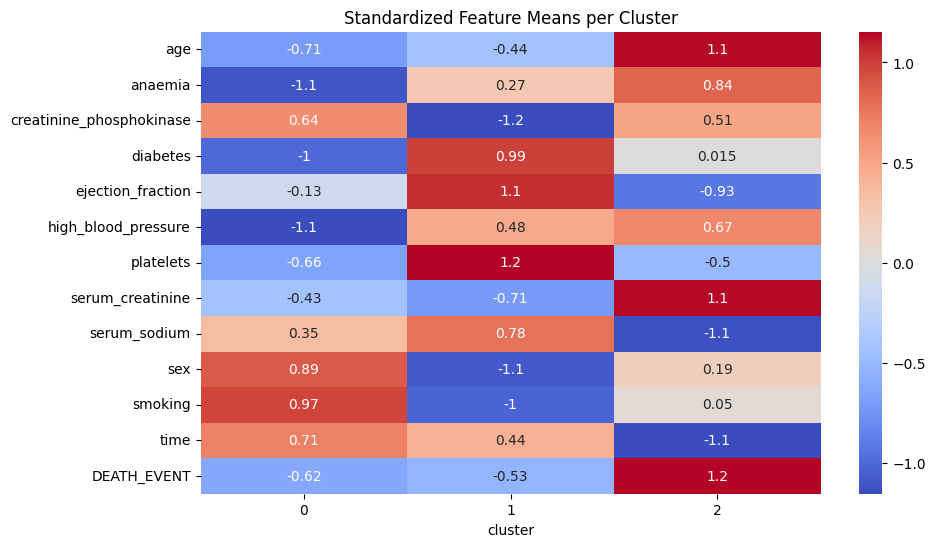

In [12]:
# Standardize the feature values (z-scores)
standardized_means = df.groupby('cluster').mean()
standardized_means = (standardized_means - standardized_means.mean()) / standardized_means.std()

# Plot the standardized heatmap
plt.figure(figsize=(10,6))
sns.heatmap(standardized_means.T, cmap='coolwarm', annot=True)
plt.title("Standardized Feature Means per Cluster")
plt.show()

Boxplots with continuous variables

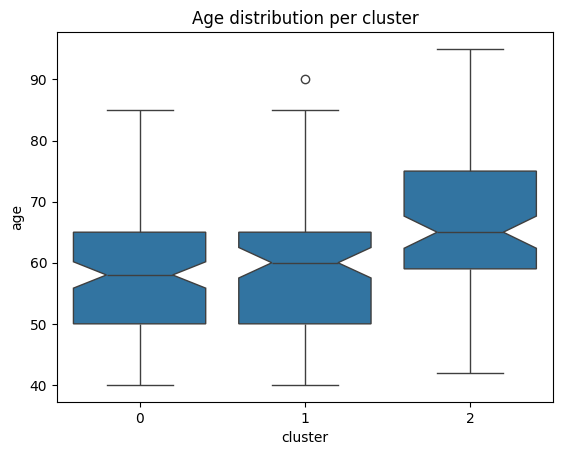

In [13]:
sns.boxplot(data=df, x='cluster', y='age',notch=True)
plt.title('Age distribution per cluster')
plt.show()


Barplot for binary variables

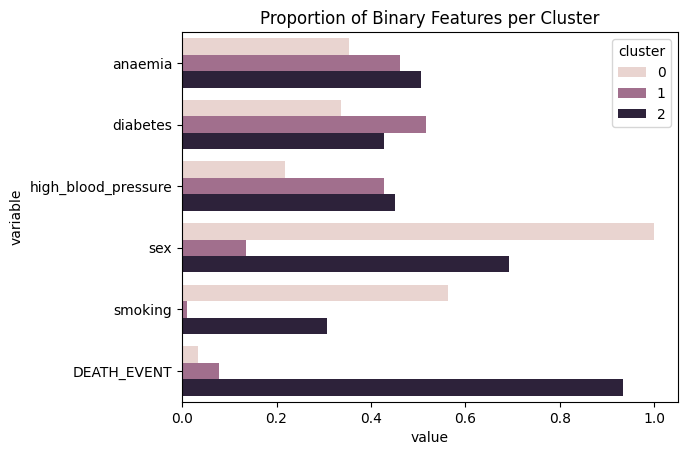

In [14]:
# Calculate the mean proportions of binary features by cluster
binary_means = df.groupby('cluster')[binary_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
binary_means_melted = binary_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=binary_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Binary Features per Cluster')
plt.show()


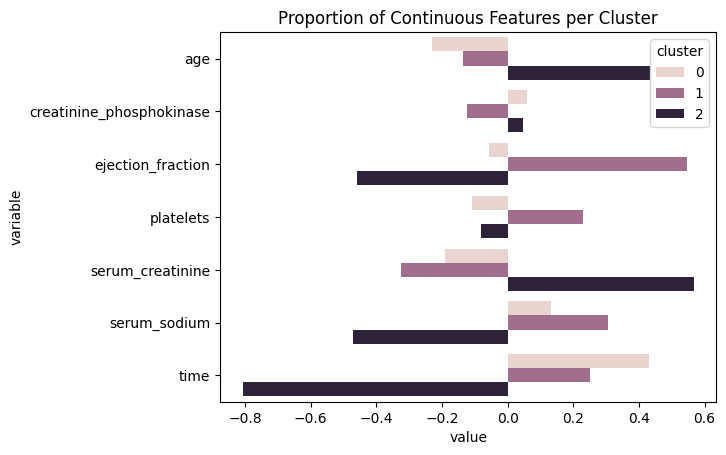

In [15]:
# Calculate the mean proportions of binary features by cluster
X_scaled['cluster'] = clusters
continuous_means = X_scaled.groupby('cluster')[continuous_vars].mean().reset_index()

# Melt the DataFrame to long format for seaborn compatibility
continuous_means_melted = continuous_means.melt(id_vars='cluster', var_name='variable', value_name='value')

# Plot the horizontal barplot
sns.barplot(data=continuous_means_melted, x='value', y='variable', hue='cluster', orient='h')
plt.title('Proportion of Continuous Features per Cluster')
plt.show()
